In [1]:
#C'est ici que toute la documentation du pipeline, les résultats et les analyses visuelles sont intégrés.
#Ce notebook contient les explications et appelle les scripts du dossier src/ pour exécuter chaque étape du pipeline.
#On l'utilise pour charger et exécuter le pipeline étape par étape. 
#Par exemple, pour exécuter la partie nettoyage, importer et exécuter data_preprocessing.py depuis src/.
#À chaque étape (nettoyage, analyse des données, visualisations), ajouter des cellules Markdown dans le notebook pour expliquer ce que fait chaque étape, pourquoi elle est nécessaire, et les observations tirées des résultats.
#C’est également ici que nous ajouterons les graphiques et analyses visuelles pour expliquer nos résultats intermédiaires.

In [2]:
#Expliquer ce que l'on fait dans notre projet et que pour ce faire nous utiliserons une version clean de movie_metadata.
#On affiche à partir de quelle année notre base de données de films commence pour exclure les évènements historiques trop lointains dans notre dataset additionnel.
#On veut garder la première colonne pour relier le film à son résumé mais aussi la plupart des autres.
#On veut transformer les formats de dates pour l’analyse temporelle.

# ADA Project - Milestone 2

First and foremost, we must setup the environment with the installation of appropriate libraries. 

In [3]:
from tests.test_data_preprocessing import test_cleaned_movie_data
import matplotlib.pyplot as plt 
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer 

Before beginning our study, we must proceed with data wrangling, transforming raw data into a structured and usable format for analysis.
This includes associating the correct names to our columns, removing outliers, nan and abherrent values and structuring our data so that it may be easier to work with. 

## 1 - Data Collection

We begin with an initial overview of the raw imported data

In [4]:
raw_movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas
print("The initial dataframe has ", len(raw_movies_data), "lines.")

The initial dataframe has  81741 lines.


In [5]:
raw_movies_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 2 - Data Cleaning 

At the first steps of our analysis, we must name the columns for clarity and remove abherrent as well as nan values.

In [6]:
headers = ["Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages (Freebase ID:name tuples)",
    "Movie countries (Freebase ID:name tuples)",
    "Movie genres (Freebase ID:name tuples)"]
raw_movies_data.columns = headers

### Handling missing values

We can use a heatmap to visualize the missing values from our raw data. Each white line corresponds to a missing value. The columns 'Movie release date', 'Movie box office revenue' and 'Movie runtime' contain a number of missing values. Let's quantify them :

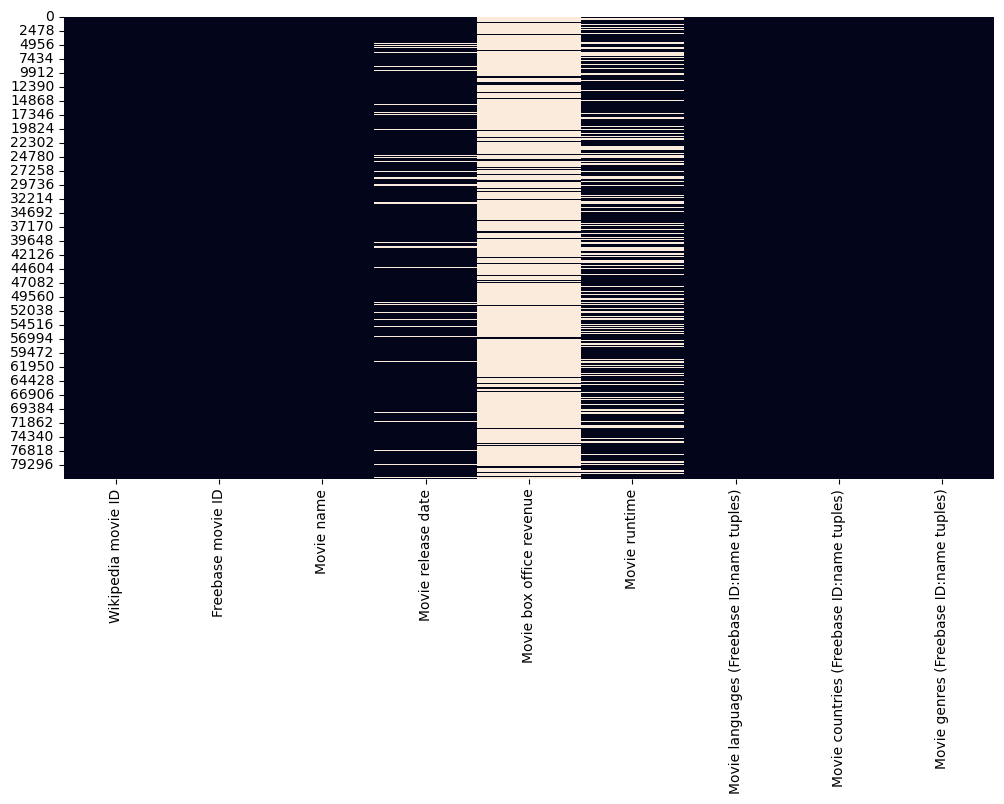

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(raw_movies_data.isnull(), cbar=False)
plt.show()

In [8]:
#compute the percentage of missing values for each column
nb_missing_values = raw_movies_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (raw_movies_data.copy().isnull().mean() * 100).sort_values(ascending=False)
#display in a dataframe
missing_values_df = pd.DataFrame({
    'Missing values': nb_missing_values,
    'Percentage (%)': missing_values_percentage
})
print(missing_values_df)

                                           Missing values  Percentage (%)
Movie box office revenue                            73340       89.722416
Movie runtime                                       20450       25.018045
Movie release date                                   6902        8.443743
Wikipedia movie ID                                      0        0.000000
Freebase movie ID                                       0        0.000000
Movie name                                              0        0.000000
Movie languages (Freebase ID:name tuples)               0        0.000000
Movie countries (Freebase ID:name tuples)               0        0.000000
Movie genres (Freebase ID:name tuples)                  0        0.000000


Almost 90% of the movies are missing the information about the box office revenue, thus we cannot drop the rows with missing value in this column.

### Handling outliers

Now that we've looked at missing values, it is time to assess for outliers and abherrent values from our data. 

#### > Movie runtime

In [9]:
raw_movies_data['Movie runtime'].describe()

count    6.129100e+04
mean     1.118192e+02
std      4.360070e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

From the boxplot and statistical description of this variable, we observe that the maximum and minimum values are outliers. We may remove them for our analysis using a certain threshold range with which we want to work with (we have a lot of values and we dont necessarily need to deal with these expections) as they only represent approximately 6% of all values.

In [10]:
def outliers_bounds(data, low_factor, up_factor):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - low_factor * IQR
    upper_bound = Q3 + up_factor * IQR
    return lower_bound, upper_bound

There are 4873 outliers among the 61291 runtime values, which corresponds to 7.95% of the values.


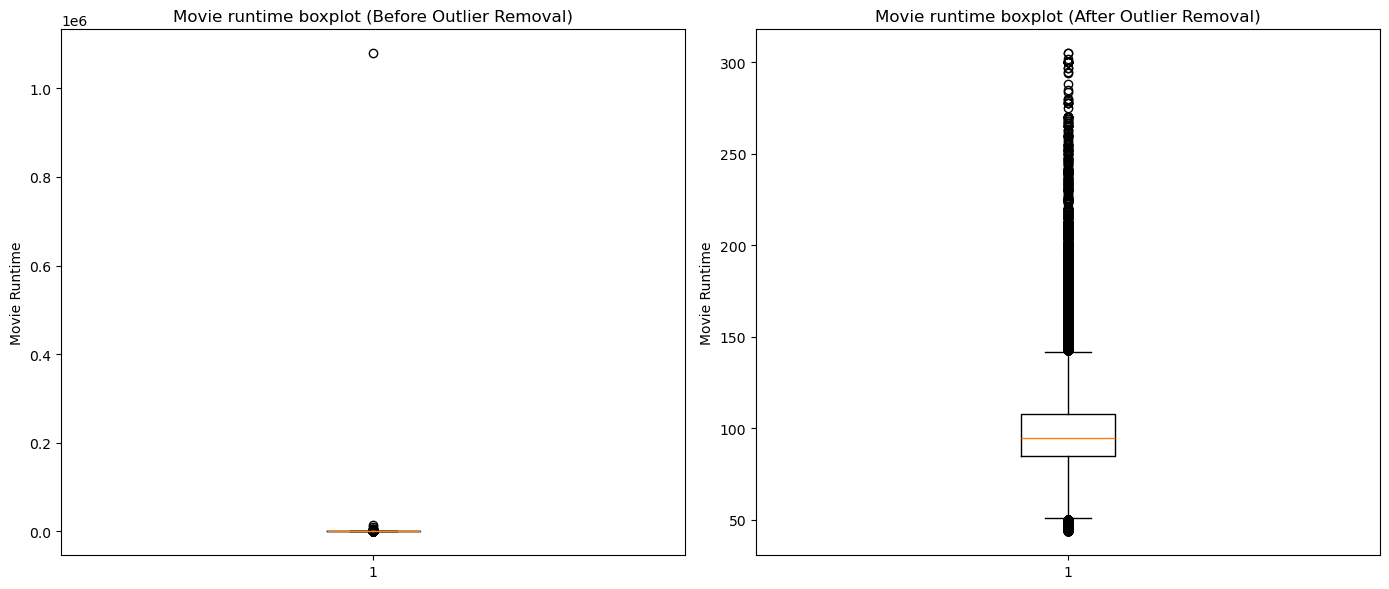

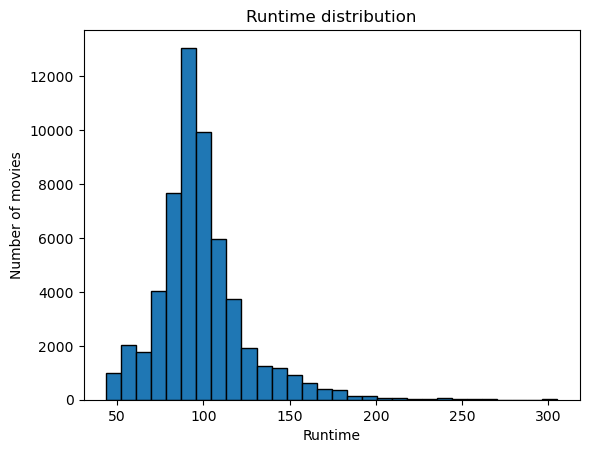

count    56418.000000
mean        98.828453
std         26.285776
min         43.716667
25%         85.000000
50%         95.000000
75%        108.000000
max        305.000000
Name: Movie runtime, dtype: float64

In [11]:
#Analysis of the column 'Runtime'
runtime_data=raw_movies_data['Movie runtime'].dropna()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Boxplot before outlier removal
ax[0].boxplot(runtime_data)
ax[0].set_title('Movie runtime boxplot (Before Outlier Removal)')
ax[0].set_ylabel('Movie Runtime')


#Identification of outliers
low_factor=1.5
up_factor = 8 #We choose a large factor because the distribution is right-skewed and we want to make sure that we do not exclude values that are not outliers
lower_bound, upper_bound=outliers_bounds(runtime_data, low_factor, up_factor)
outliers = runtime_data[(runtime_data < lower_bound) | (runtime_data > upper_bound)]
print(f"There are {len(outliers)} outliers among the {len(runtime_data)} runtime values, which corresponds to {len(outliers)/len(runtime_data)*100:.2f}% of the values.")

#Remove the outliers from the dataset
clean_movies_data = raw_movies_data[(raw_movies_data['Movie runtime'] >= lower_bound) & (raw_movies_data['Movie runtime'] <= upper_bound)]

# Boxplot after outlier removal
ax[1].boxplot(clean_movies_data['Movie runtime'])
ax[1].set_title('Movie runtime boxplot (After Outlier Removal)')
ax[1].set_ylabel('Movie Runtime')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


#Runtime distribution
plt.figure()
plt.hist(clean_movies_data['Movie runtime'], bins=30, edgecolor='black')
plt.title('Runtime distribution')
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.show()

clean_movies_data['Movie runtime'].describe()

#### > Box Office

In [12]:
raw_movies_data['Movie box office revenue'].describe()

count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

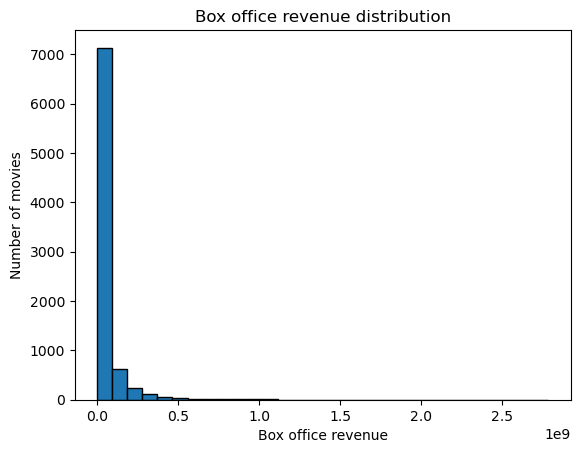

In [13]:
#Box office revenue distribution
plt.figure()
plt.hist(clean_movies_data['Movie box office revenue'], bins=30, edgecolor='black')
plt.title('Box office revenue distribution')
plt.xlabel('Box office revenue')
plt.ylabel('Number of movies')
plt.show()

In [14]:
top_10_box_office = raw_movies_data.sort_values(by='Movie box office revenue', ascending=False).head(10)
top_10_box_office

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
30278,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
54719,29075630,/m/0bpm4yw,The Dark Knight Rises,2012-07-16,1.078009e+09,165.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
69586,1213838,/m/04hwbq,Toy Story 3,2010-06-12,1.063172e+09,102.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil..."
14303,24314116,/m/09v8clw,Pirates of the Caribbean: On Stranger Tides,2011-05-07,1.043872e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02qvnvs"": ""Swashbuckler films"", ""/m/03k9f..."
50039,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999-05-19,1.027045e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."


There does not seem to be any significant outliers in this variable. This is reassuring because we are already quite limited in terms of number of instances as there are a great number of missing values for it.

### > Data processing

In [15]:
#remove unnecessary columns
preprocessed_movies_data=raw_movies_data.drop(columns=["Wikipedia movie ID","Freebase movie ID"])
preprocessed_movies_data.head()
len(preprocessed_movies_data)

81741

In [16]:
def extract_names(cell):
    #Transform the string of dictionaries into a list of real dictionaries with the id referring to the key and the name referring to the value
    #Then only extract the names from the dictionaries
    try:
        data_dict = ast.literal_eval(cell)
        return ", ".join(data_dict.values())
    except (ValueError, SyntaxError):
        return cell


In [17]:
#remove the id, only keep the name
preprocessed_movies_data["Movie languages"] = preprocessed_movies_data["Movie languages (Freebase ID:name tuples)"].apply(extract_names)
preprocessed_movies_data["Movie countries"] = preprocessed_movies_data["Movie countries (Freebase ID:name tuples)"].apply(extract_names)
preprocessed_movies_data["Movie genres"] = preprocessed_movies_data["Movie genres (Freebase ID:name tuples)"].apply(extract_names)
preprocessed_movies_data.drop(columns=["Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"], inplace=True)


In [18]:
preprocessed_movies_data.info()
len(preprocessed_movies_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                81741 non-null  object 
 1   Movie release date        74839 non-null  object 
 2   Movie box office revenue  8401 non-null   float64
 3   Movie runtime             61291 non-null  float64
 4   Movie languages           81741 non-null  object 
 5   Movie countries           81741 non-null  object 
 6   Movie genres              81741 non-null  object 
dtypes: float64(2), object(5)
memory usage: 4.4+ MB


81741

In [19]:
#All the films that have no genre indicated are tranformed into NaN

preprocessed_movies_data['Movie genres'] = preprocessed_movies_data['Movie genres'].apply(lambda x: np.nan if x == '' else x)


In [20]:
#Then the lines with nan values in genre are removed
preprocessed_movies_data= preprocessed_movies_data.dropna(subset=["Movie genres"])
len(preprocessed_movies_data)

79447

We don't lose a lot of data by dropping the NA, so the analysis will stay pertinent

### Time Process

We only keep the year of the film and drop the movies without any date (6000 values)

In [21]:
timeprocess_movies_data = preprocessed_movies_data.dropna(subset=["Movie release date"]).copy()
print(len(timeprocess_movies_data))    


73077


Je comprend pas pourquoi les dates s affichent en .0 ??

In [22]:
def extract_year(date_str):
    if len(date_str) == 4 and date_str.isdigit():
        return date_str
    else:
        # Use pd.to_datetime for other formats and extract year
        return pd.to_datetime(date_str, errors='coerce').year

In [23]:
timeprocess_movies_data['Year'] = timeprocess_movies_data['Movie release date'].apply(extract_year)
timeprocess_movies_data.drop(columns=["Movie release date"], inplace=True)
timeprocess_movies_data.head(2)

,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000


In [24]:
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'

# Sauvegarder le DataFrame transformé
timeprocess_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

### > Extra-preprocessing steps

As extra pre-processing steps to prep the data, we removed the films which had no genres indicated as they cannot contribute to our study. This is feasable as only a small number of movies had not genres.
We also removed the "Wikipedia movie ID" and "Freebase movie ID" columns as they had no contribution to our study.

In [25]:
preprocessed_movies = pd.read_csv("data/preprocessed_data/preprocessed_movie_metadata.csv")
print("The dataframe following preprocessing steps has ", len(preprocessed_movies), "lines.")
print(len(raw_movies_data) - len(preprocessed_movies), " lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  73077 lines.
8664  lines were lost following the cleaning steps.


In [26]:
preprocessed_movies.head()

,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0
2,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988.0
3,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0
4,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,1983.0


In [27]:
preprocessed_movies.describe()

,Movie box office revenue,Movie runtime,Year
count,8.323000e+03,5.820600e+04,73076.000000
mean,4.828817e+07,1.124090e+02,1977.445536
std,1.124909e+08,4.473623e+03,29.019725
min,1.000000e+04,0.000000e+00,1888.000000
25%,2.102500e+06,8.100000e+01,1955.000000
50%,1.082781e+07,9.300000e+01,1985.000000
75%,4.113620e+07,1.060000e+02,2004.000000
max,2.782275e+09,1.079281e+06,2016.000000


## 3 - Preliminary Data Analysis

## Number of film per year

It is important to note for our future analysis that the number of films produced each year is not uniform. This variability should be considered when comparing film counts over time. In some cases, working with proportions rather than absolute numbers may provide us more interesting insights.


Text(0.5, 1.0, 'Number of movies per year')

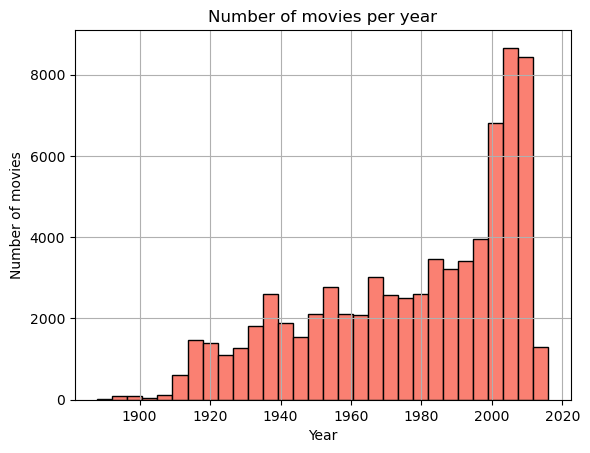

In [28]:
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")

# Genre Movie exploring

In [29]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Movie genres'].str.split(', ').explode().unique()
print(len(genres),genres)

363 ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom Drama'
 'Culture & Society' 'Biography' 'Documentary' 'Christmas movie'
 'Television movie

There are 363 different genres, many genres are used to described the film. Here a genre regroup a lot of information: the thematic, the technical characteristics, ... 
Clearly, not all of these information are useful for our analysis. We need to select to best to regroup the film in a meaningful way.

Let's count the number of movies in each genre category.

In [30]:
genres_counts = preprocessed_movies['Movie genres'].str.split(', ').explode().value_counts()
genres_counts

Movie genres
Drama                   32015
Comedy                  15648
Romance Film             9770
Black-and-white          8817
Thriller                 8408
                        ...  
Comdedy                     1
C-Movie                     1
Linguistics                 1
Silhouette animation        1
Homoeroticism               1
Name: count, Length: 363, dtype: int64

In [31]:
#Genres assigned to 10 movies or less
rare_genres = genres_counts[genres_counts <= 10]
rare_genres_counts = len(rare_genres)

print(f"Number of genres assigned to 10 movies or less  : {rare_genres_counts}")

Number of genres assigned to 10 movies or less  : 87


A lot of genres might not be meaningful because they contain few movies. In particular, 87 genres are assigned to 10 movies or less.
In order to keep only relevant genres, we can define an arbitrary threshold for the number of movies assigned to each genre.

In [32]:
#Threshold
threshold=50
# Garder uniquement les genres assignés à plus de 50 films
relevant_genres = genres_counts[genres_counts > 50]
print(f"Number of genres assigned to more than 500 movies : {len(relevant_genres)}")

Number of genres assigned to more than 500 movies : 197


Now we look at the distribution of the most widespread genres.

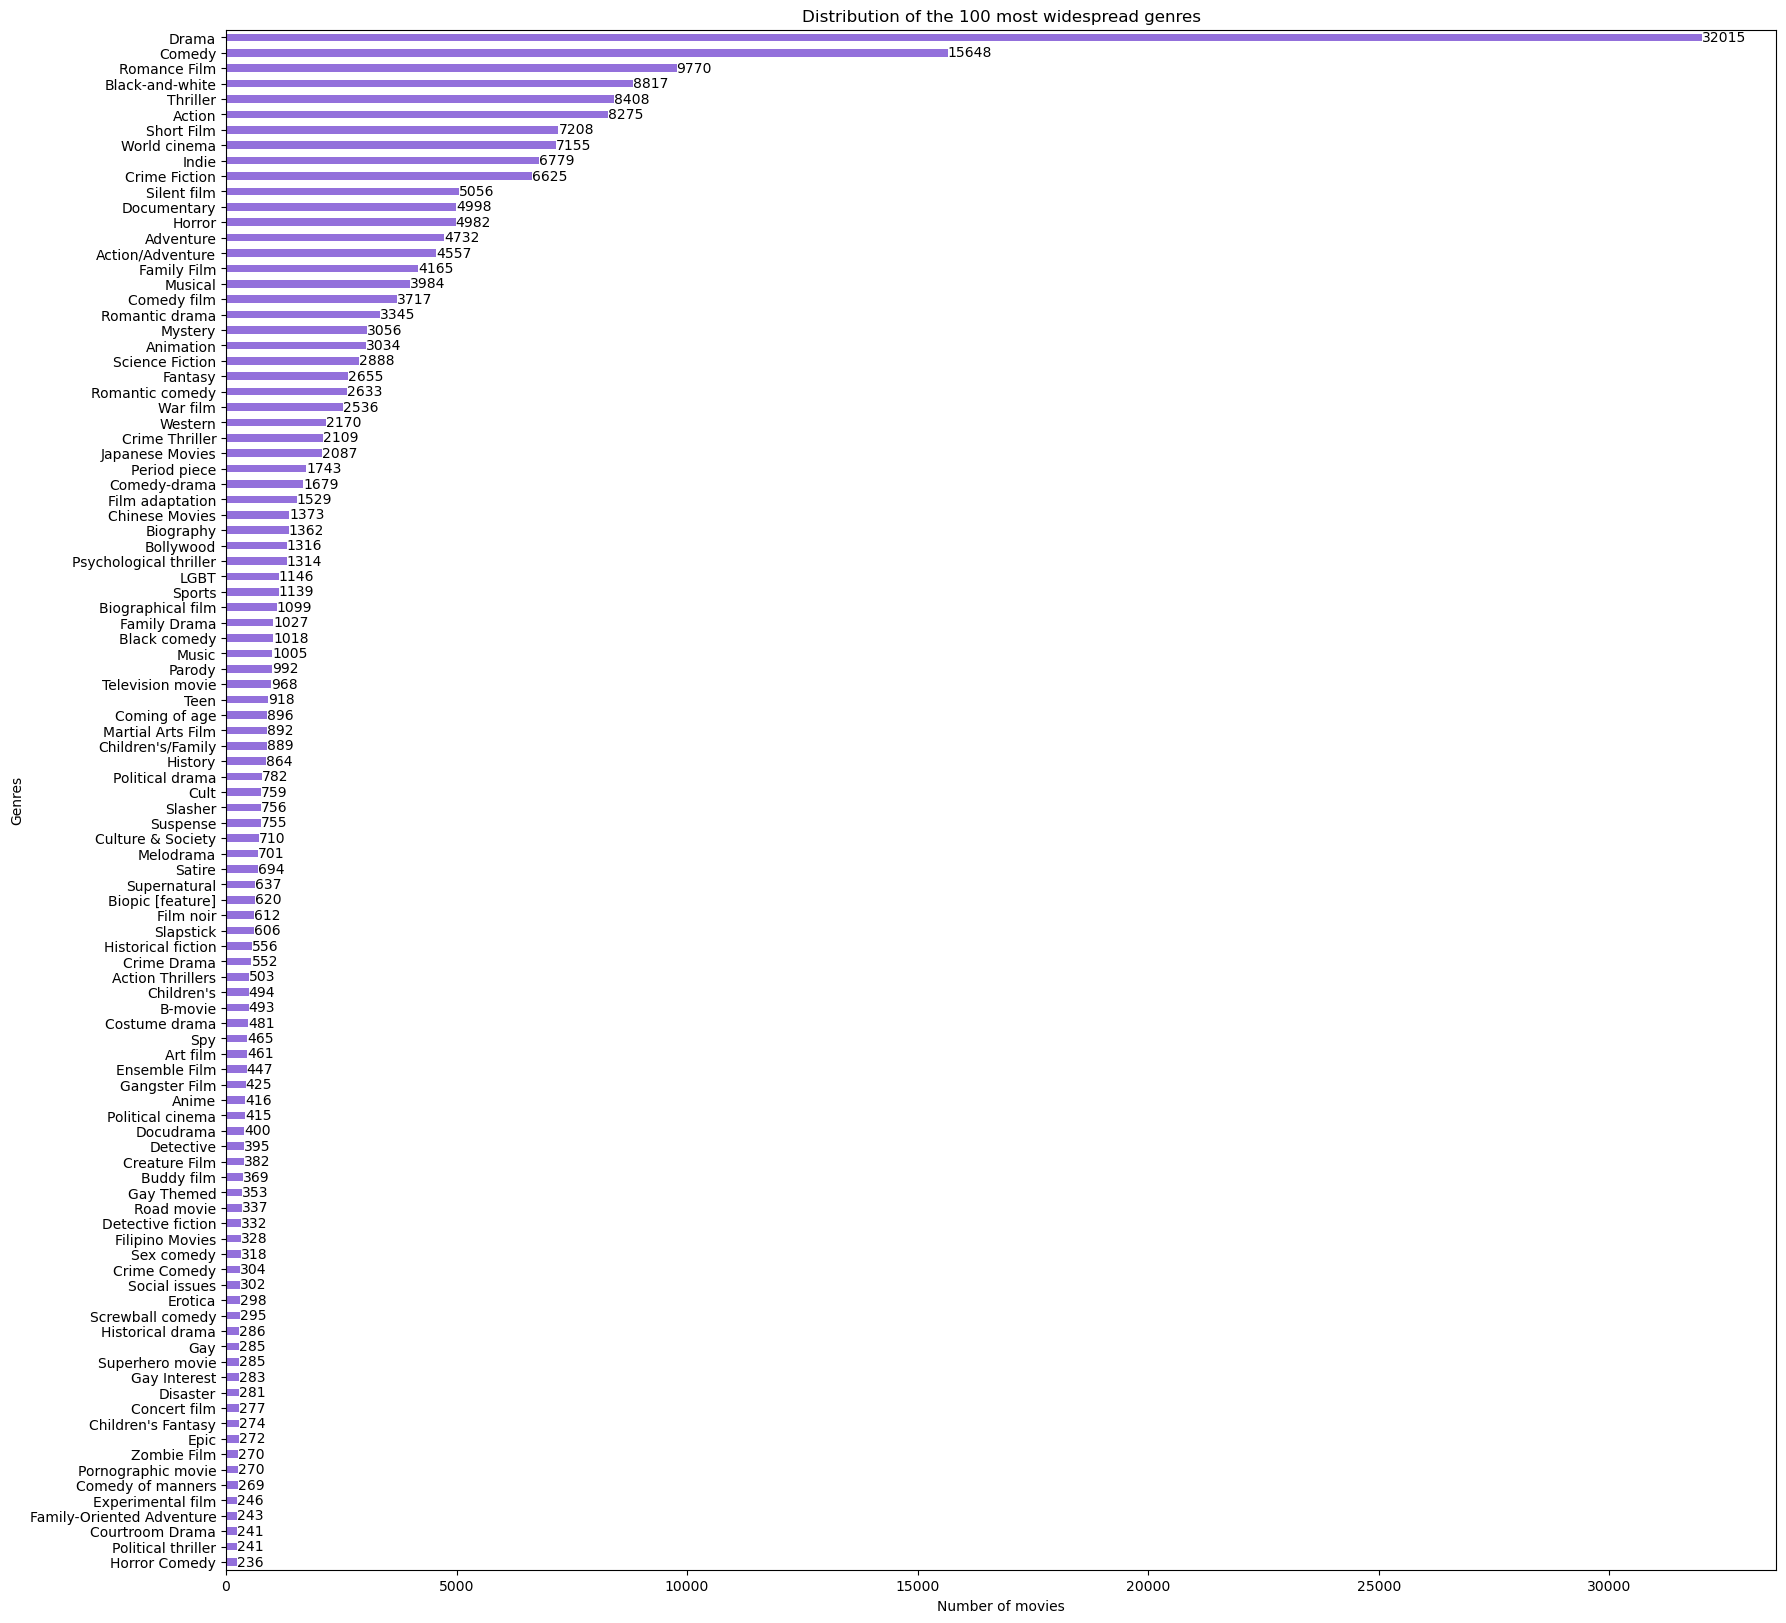

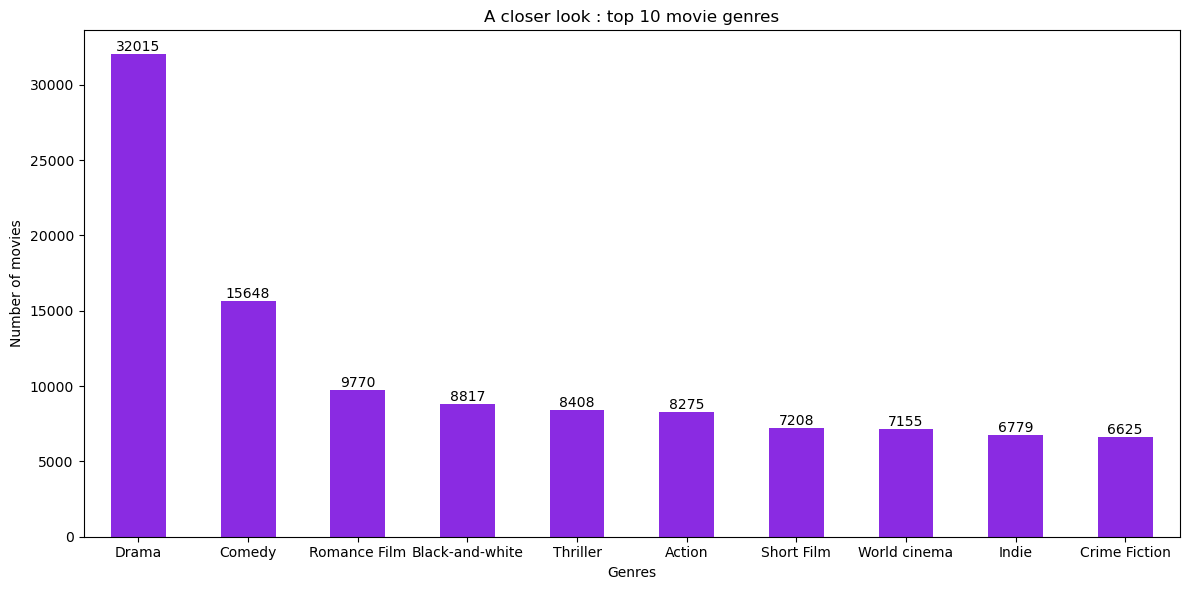

In [33]:
#We choose the 100 most widespread genres
top_100_genres = relevant_genres.head(100)

#Genres distribution
plt.figure(figsize=(20, 20))
top_100_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies')
plt.ylabel('Genres')
plt.title('Distribution of the 100 most widespread genres')
plt.gca().invert_yaxis() 

#Display the number of movies for each genre category
for index, value in enumerate(top_100_genres):
    plt.text(value, index, str(value), va='center')
    
plt.show()


#A closer look : top 10 movie genres
top_10_genres = relevant_genres.head(10)

#Bar plot 
plt.figure(figsize=(12, 6))
top_10_genres.plot(kind='bar', color='#8A2BE2')
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('A closer look : top 10 movie genres')

#Display the number of movies for each genre category
for index, value in enumerate(top_10_genres):
    plt.text(index, value + 200, str(value), ha='center')
    
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

## Petite tentative pour observer les war movies

In [34]:
War_movies = preprocessed_movies[preprocessed_movies['Movie genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Movie genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Movie genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

2550 228 1697


Text(0.5, 1.0, 'Number of movies per year')

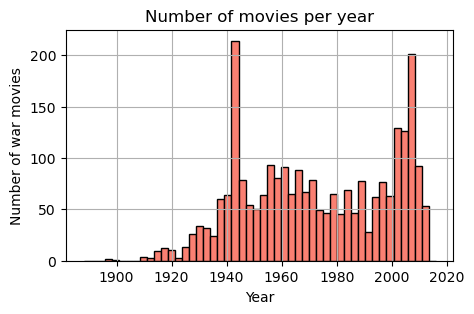

In [35]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

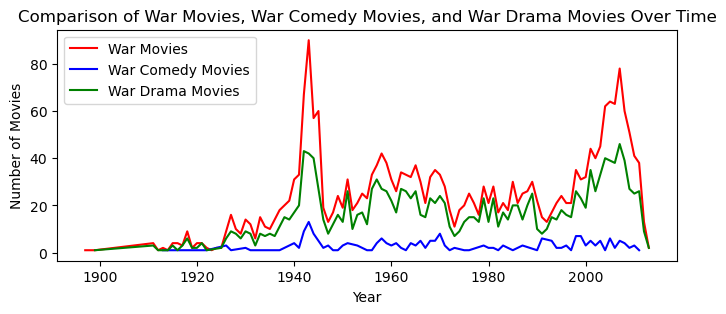

In [36]:
plt.figure(figsize=(8, 3))

# Count the number of movies in each category per year
war_movies_per_year = War_movies.groupby('Year').size()
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Plot the data
plt.plot(war_movies_per_year.index, war_movies_per_year.values, label='War Movies', color='red')
plt.plot(war_comedy_movies_per_year.index, war_comedy_movies_per_year.values, label='War Comedy Movies', color='blue')
plt.plot(war_drama_movies_per_year.index, war_drama_movies_per_year.values, label='War Drama Movies', color='green')

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Comparison of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend()
plt.show()



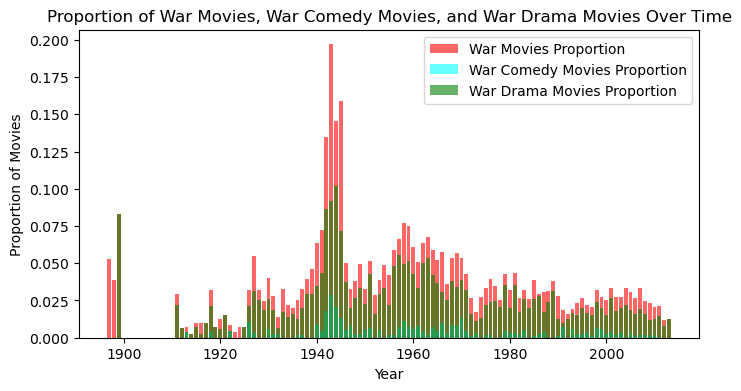

In [37]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

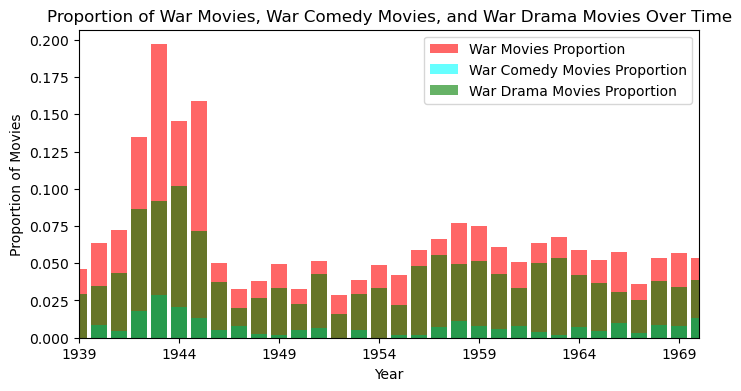

In [38]:
plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.xlim(1939, 1970)
plt.xticks(np.arange(1939, 1971, 5))
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

## Code qui vient de la branche de Lucile : Comment expliquer la variance des films avec un plus petit nombre de genres

In [39]:
#remove all the genre that give information about the technical aspect of the movie rather than the content
technical_information = ['Silent film','Short Film','Musical', 'Film adaptation',"Black-and-white", "Music", "Teen", "Stop Motion"]
country_information = ["Indie","Japanese Movies", "Chinese Movies", "Bollywood"]
unwanted_genres = technical_information + country_information


def filter_genres(genre_list, unwanted_genres):
    if isinstance(genre_list, str):
        genres = genre_list.split(', ')
        filtered_genres = [genre for genre in genres if genre not in unwanted_genres]
        return ', '.join(filtered_genres)
    return genre_list

preprocessed_movies['Movie genres'] = preprocessed_movies['Movie genres'].apply(lambda x: filter_genres(x, unwanted_genres=unwanted_genres))

In [40]:
genre_movies = preprocessed_movies['Movie genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']
genre_counts.head(4)

,Genre,Count
0,Drama,32015
1,Comedy,15648
2,Romance Film,9770
3,Thriller,8408


In [41]:
genre_counts_top_100 = genre_counts.iloc[:100]
genre_counts_top_30 = genre_counts.iloc[:30]
genre_counts_top_10 = genre_counts.iloc[:10]
genre_counts_top_3 = genre_counts.iloc[:3]

<Axes: xlabel='Genre'>

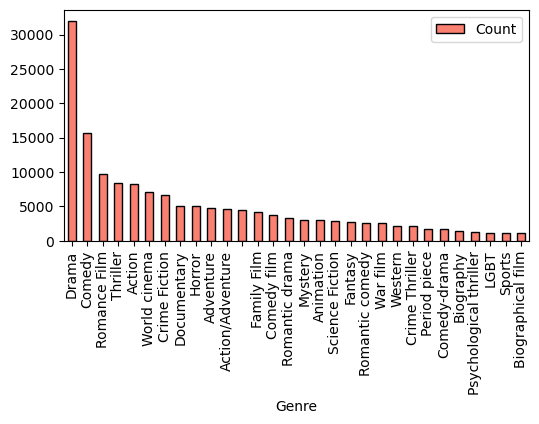

In [42]:
genre_counts_top_30.plot(kind='bar', x='Genre', y='Count', color='salmon', edgecolor='black', figsize=(6, 3))

In [43]:
def keep_only_the_most_common_genres(genre_list, genre_counts):
    if isinstance(genre_list, str):
        genres = genre_list.split(', ')
        filtered_genres = [genre for genre in genres if genre in genre_counts['Genre'].values]
        return ', '.join(filtered_genres)
    return genre_list

In [44]:
def most_common_genres(movies, genre_counts, top_n):
    movies_common_genre = movies.copy()

    #keep only the n top genres and replace the empty line by nan values
    movies_common_genre['Movie genres'] = movies_common_genre['Movie genres'].apply(lambda x: keep_only_the_most_common_genres(x, genre_counts=genre_counts))
    movies_common_genre['Movie genres'] = movies_common_genre['Movie genres'].apply(lambda x: np.nan if x == '' else x)
    
    #compute the portion of film qualified by the top n genre
    total = len(movies)
    covered = total - movies_common_genre['Movie genres'].isna().sum()
    coverage = (covered / total) * 100
    
    return movies_common_genre, coverage

# Define a list of genre counts for each top N genres
genre_counts_list = [genre_counts_top_100, genre_counts_top_30, genre_counts_top_10, genre_counts_top_3]
top_n_values = [100, 30, 10, 3]


coverages = {}
for top_n, genre_counts in zip(top_n_values, genre_counts_list):
    _, coverage = most_common_genres(preprocessed_movies, genre_counts, top_n)
    coverages[top_n] = coverage

for top_n, coverage in coverages.items():
    print(f"Number of films covered by the {top_n} major genres: {coverage:.2f}%")

print("-"*32)
print(f"60% of the film are classified into the third major genres that are \n" , genre_counts_top_3['Genre'].values,  f"\nUp to 91% of the film are classified into the 30 major genres that are: \n", genre_counts_top_10['Genre'].values)
print(f"\nThus by a few genre we can cover a large part of the movies, \nbut the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified")



Number of films covered by the 100 major genres: 93.47%
Number of films covered by the 30 major genres: 91.70%
Number of films covered by the 10 major genres: 83.44%
Number of films covered by the 3 major genres: 61.73%
--------------------------------
60% of the film are classified into the third major genres that are 
 ['Drama' 'Comedy' 'Romance Film'] 
Up to 91% of the film are classified into the 30 major genres that are: 
 ['Drama' 'Comedy' 'Romance Film' 'Thriller' 'Action' 'World cinema'
 'Crime Fiction' 'Documentary' 'Horror' 'Adventure']

Thus by a few genre we can cover a large part of the movies, 
but the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified


Let's try to do a heatmap to see if some genre are often associated together in a movie

In [45]:
most_10commongenres,coverage10 = most_common_genres(preprocessed_movies, genre_counts_top_10, 10)
most_10commongenres = most_10commongenres.dropna(subset=['Movie genres'])

In [46]:
#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_10commongenres['Movie genres'].str.split(', ')), columns=mlb.classes_, index=most_10commongenres.index)
genre_correlation = genre_binary_matrix.corr()


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

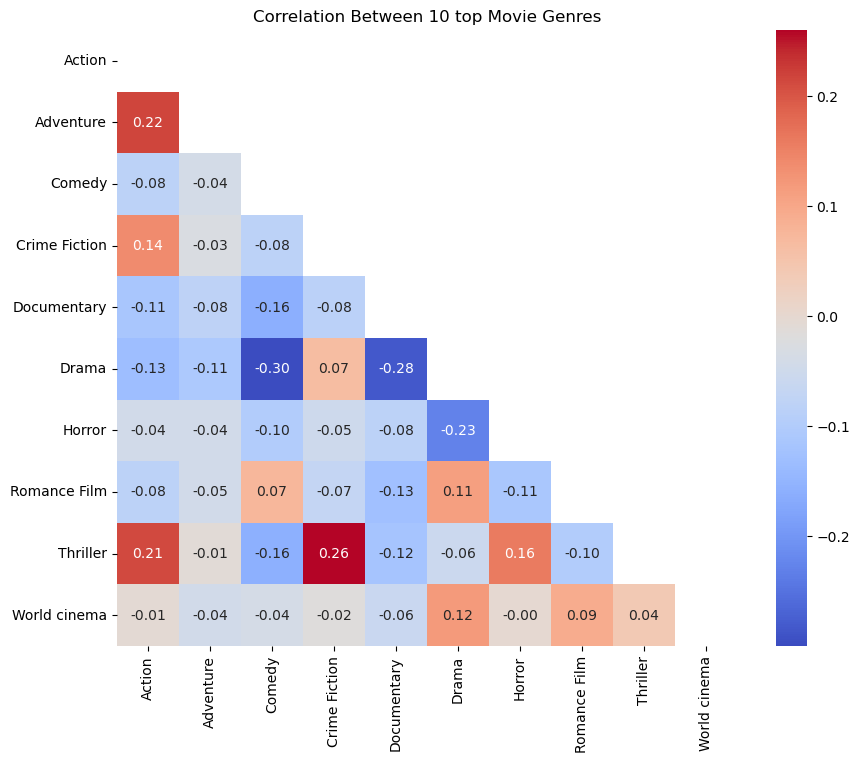

In [47]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

This heatmap show how often 2 genres are used at the same time to describe the same moovie. 
For instance, between Adventure & Action (0.22): There is a moderate positive correlation, suggesting that movies in the "Adventure" genre often have elements of "Action" and vice versa. It shows a slight tendency for these genres to appear together in the same movies, but this co-occurrence is not strong or highly consistent across the dataset
Or between Drama & Documentary: there is a strong negative correlation indicates that movies classified as "Drama" are less likely to be "Documentary" and vice versa. Here the tendency for these 2 genre to not appear together in the same movie is stronger.

### Let's try this heat map for the top 30 genres

In [48]:
most_30commongenres,coverage30 = most_common_genres(preprocessed_movies, genre_counts_top_30, 30)
most_30commongenres = most_30commongenres.dropna(subset=['Movie genres'])

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_30commongenres['Movie genres'].str.split(', ')), columns=mlb.classes_, index=most_30commongenres.index)
genre_correlation = genre_binary_matrix.corr()

print(genre_correlation.index)

Index(['Action', 'Action/Adventure', 'Adventure', 'Animation',
       'Biographical film', 'Biography', 'Comedy', 'Comedy film',
       'Comedy-drama', 'Crime Fiction', 'Crime Thriller', 'Documentary',
       'Drama', 'Family Film', 'Fantasy', 'Horror', 'LGBT', 'Mystery',
       'Period piece', 'Psychological thriller', 'Romance Film',
       'Romantic comedy', 'Romantic drama', 'Science Fiction', 'Sports',
       'Thriller', 'War film', 'Western', 'World cinema'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

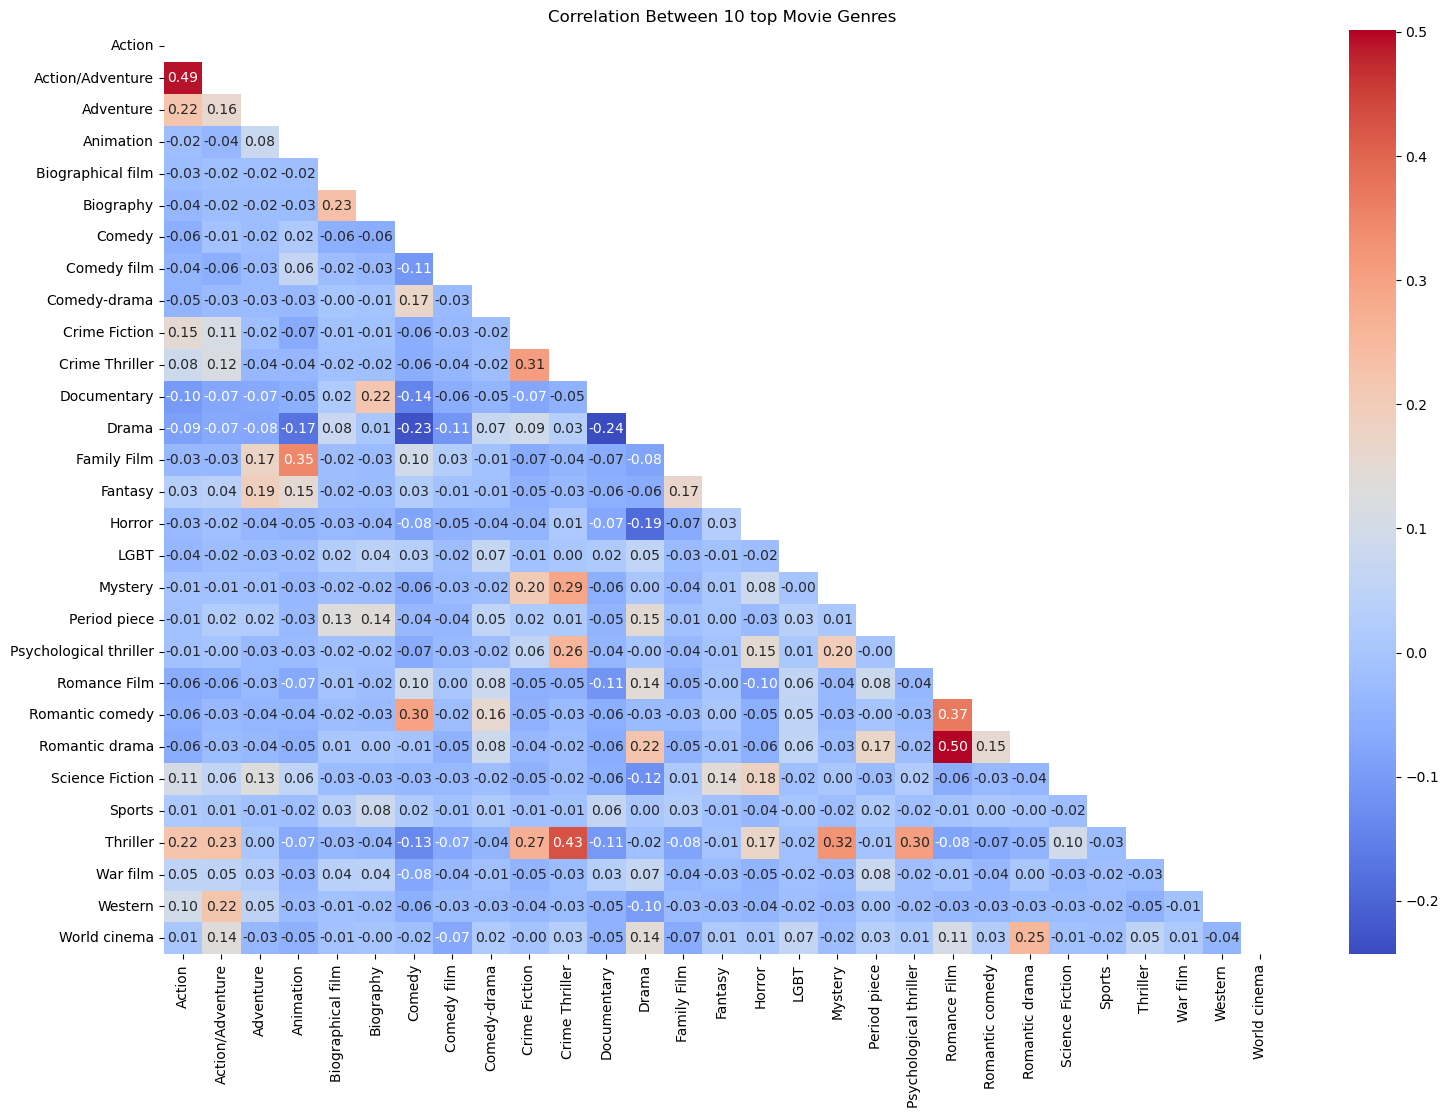

In [49]:
plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

Here, we observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

## Brouillon de Lucile (commenté car il y a des erreurs)
-> "selected_genres" not defined 

In [50]:
# Create a new DataFrame to store the count of movies per year for each genre
# genre_year_df = preprocessed_movies[['Year', 'Movie genres']].copy()

# Explode the genres into separate rows
# genre_year_df = genre_year_df.assign(Movie_genres=genre_year_df['Movie genres'].str.split(', ')).explode('Movie genres')

# Filter the DataFrame to include only the selected genres
# genre_year_df = genre_year_df[genre_year_df['Movie genres'].isin(selected_genres)]

# Group by year and genre, and count the number of movies
# genre_year_counts = genre_year_df.groupby(['Year', 'Movie genres']).size().unstack(fill_value=0)

C:\Users\lauri\AppData\Local\Temp\ipykernel_18952\2027056179.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


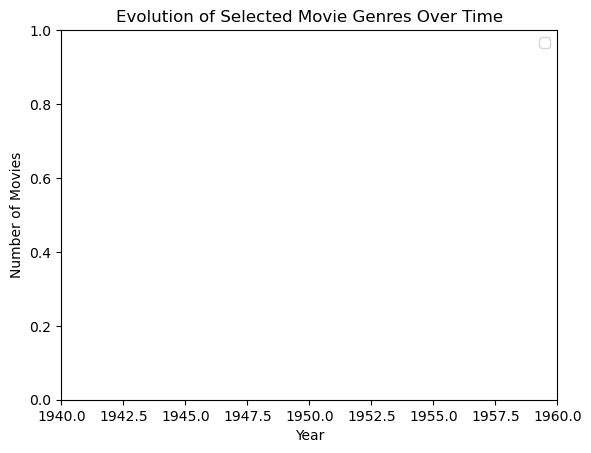

In [51]:
# Plot the evolution over time for each genre
#plt.figure(figsize=(14, 8))
#for genre in selected_genres:
#   plt.plot(genre_year_counts.index, genre_year_counts[genre], label=genre)

# Set the range for the x-axis
plt.xlim(1940, 1960)

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Selected Movie Genres Over Time')
plt.legend()


In [52]:
genre_movies = preprocessed_movies['Movie genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

In [53]:
len(genre_counts)

353

In [54]:
genre_counts_processed = genre_counts[genre_counts['Count'] > 100]
genre_counts_processed.head(30)


,Genre,Count
0,Drama,32015
1,Comedy,15648
2,Romance Film,9770
3,Thriller,8408
4,Action,8275
5,World cinema,7155
6,Crime Fiction,6625
7,Documentary,4998
8,Horror,4982
9,Adventure,4732


In [55]:
#HEATMAP 

In [56]:
Thriller_movies = preprocessed_movies[preprocessed_movies['Movie genres'].str.contains(r'Thriller', case=False, na=False)]
Thriller_movies.head(13)

,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
3,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0
11,Lady Snowblood 2: Love Song of Vengeance,NaN,89.0,Japanese Language,Japan,"Crime Fiction, Thriller, World cinema, Action/...",1974.0
19,New Rose Hotel,21521.0,92.0,English Language,United States of America,"Thriller, Science Fiction, Future noir, Erotic...",1999.0
30,Special Effects,NaN,93.0,NaN,"United States of America, United Kingdom","Thriller, Horror, Psychological thriller, Susp...",1984.0
49,Kinjite: Forbidden Subjects,3416846.0,97.0,English Language,United States of America,"Crime Fiction, Action/Adventure, Action, Thriller",1989.0
61,Mesmerized,NaN,94.0,English Language,"Australia, United Kingdom, New Zealand","Thriller, Crime Fiction, World cinema, Psychol...",1986.0
71,Shivers,NaN,89.0,English Language,Canada,"Science Fiction, Horror, Erotica, Sci-Fi Horro...",1975.0
79,Sombra Verde,NaN,85.0,Spanish Language,Mexico,"Action/Adventure, Thriller, Drama, Adventure, ...",1954.0
92,The Boston Strangler,17810894.0,116.0,English Language,United States of America,"Crime Fiction, Mystery, Thriller, Drama, Crime...",1968.0


COMMENT ON CHOISIT LES CATEGORIES QU ON VEUT GARDER? 
- est ce qu on en combine, est ce on drop celle qui ont le moins de films, est ce qu on fait une selection manuelle?

# FIN DU RANDOM 

# Additional dataset : "World Important Events - Ancient to Modern"

Enfin, on veut clean notre dataset additionnel, création de catégories utiles pour l’analyse, comme « guerre », « crise économique », « période de stabilité ». On cherche encore ici à vectoriser et mettre sous forme de token certains types de mots en identifiant les catégories qui nous intéressent.
On veut éliminer les valeurs manquantes ainsi que les événements historiques beaucoup trop vieux pour notre analyse.
Peu importe la méthode utilisée pour tokeniser/vectroriser, expliquer ici pourquoi c'est approprié pour nos objectif et donner une  brève explication mathématique si possible.
On veut aussi transformer les formats de dates pour l’analyse temporelle à l'image de notre movie dataset.

In [57]:
from tests.test_data_preprocessing import test_cleaned_historical_data, test_vectorized_historical_data
import pandas as pd

history_data = pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
movies_data = pd.read_csv("data/Preprocessed_data/preprocessed_movie_metadata.csv")
history_data.head()

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed
3,7,Battle of Panipat,21,April,1526,India,Battle,Panipat,Foundation of the Mughal Empire in India,Northern Indian kingdoms,Babur,Mixed
4,8,Establishment of British Raj,1,May,1858,India,Colonial,Whole India,Start of direct British governance in India,Indian subcontinent,British East India Company/Empire,Negative


In [58]:
len(history_data)

1096

We can remove the columns "Place Name","Date" and "Month" of the dataset. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries.

In [59]:
# drop columns that we don't need.
history_data.drop(columns=["Place Name","Date", "Month"], inplace=True)
len(history_data)

1096

In [60]:
# we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time
def remove_BC(data):
    clean_data = data[~data['Year'].str.contains('BC')]
    return clean_data
    
cleaned_data_history = remove_BC(history_data)

In [61]:
# the historical dataset starts from very ancient times, we want to only keep events happening after the first movie was released
# for this purpose, we need to make the date values more convenient to work with, by converting the column ['Year'] from str to int
cleaned_data_history.loc[:, 'Year'] = cleaned_data_history.loc[:, 'Year'].astype(int)
    
# get the year of the first released movie
first_movie_year = movies_data['Year'].min()
print('\n In our dataset, the first movie that was released was in', int(first_movie_year))
    
# remove historical events that happened before the first movie was released
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] >= first_movie_year]
first_event_year = cleaned_data_history['Year'].min()

print('\n The first event in the historical dataset that happened after the first movie was released was in', int(first_event_year))


 In our dataset, the first movie that was released was in 1888

 The first event in the historical dataset that happened after the first movie was released was in 1888


In [62]:
# save the cleaned data to a csv file
processed_data_path = 'data/Preprocessed_data/preprocessed_history.csv'
cleaned_data_history.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)


At the end, a new csv file containing the cleaned data was created, in the file preprocessed_history.csv

In [63]:
preprocessed_history = pd.read_csv("data/Preprocessed_data/preprocessed_history.csv")
preprocessed_history.head()

,Sl. No,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,9,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
1,10,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative
2,11,PokhranUnknownII Nuclear Tests,1998,India,Nuclear Test,India declared itself a nuclear state,International community,Atal Bihari Vajpayee,Mixed
3,12,Mumbai Terror Attacks,2008,India,Terrorism,Highlighted the threat of international terrorism,Citizens of Mumbai,LashkarUnknowneUnknownTaiba,Negative
4,16,Swadeshi Movement,1905,India,National Movement,Promoted Indian goods; protest against British...,Indian nationalists,Indian National Congress,Positive


In [64]:
len(preprocessed_history)

814

In [65]:
preprocessed_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Sl. No                              814 non-null    int64 
 1   Name of Incident                    814 non-null    object
 2   Year                                814 non-null    int64 
 3   Country                             814 non-null    object
 4   Type of Event                       814 non-null    object
 5   Impact                              814 non-null    object
 6   Affected Population                 814 non-null    object
 7   Important Person/Group Responsible  814 non-null    object
 8   Outcome                             814 non-null    object
dtypes: int64(2), object(7)
memory usage: 57.4+ KB


There are no missing values in the cleaned data history. 

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)
